# Imports

In [1]:
import wmfdata
import pandas as pd
from IPython.display import clear_output

# spark docs: https://github.com/wikimedia/wmfdata-python/blob/main/docs/quickstart.ipynb
spark = wmfdata.spark.create_session(type='yarn-regular', app_name="copyedit-research", ship_python_env=True)

spark.sparkContext.addPyFile("../scripts/extract_wiktionary_misspellings.py")

import extract_wiktionary_misspellings

clear_output()

spark

## Gather wiktionary pages and parse templates

In [ ]:
extract_wiktionary_misspellings.extract_and_save_misspelling(snapshot='2023-01', dbname='enwiktionary',
                                                             filename='../resources/enwiktionary_common_misspellings.tsv',
                                                             _spark = spark)

In [5]:
df = pd.read_csv('../resources/enwiktionary_common_misspellings.tsv', sep="\t").dropna()
df["templates"] = df["templates"].apply(lambda x: eval(x))

## Analyze misspellings

In [39]:
# check rows where num_definitions != num_templates
check_df = df[df["num_definitions"]!=df["num_templates"]]
print(len(check_df))
check_df[check_df["num_definitions"]>4].head(50)

838


page_id  page_title         l2_heading  num_definitions  num_templates  \
15    6914669         มุข               thai                6              1   
271     19005      wallah            english                5              1   
415     87066      backup            english                8              1   
450     61066        vail            english               12              2   
451    191113       grill            english               21              1   
879     55294      hurdle            english               10              2   
936    250626     payback            english                5              1   
967     37536          da            italian               13              1   
1085    79862      rigour            english                7              1   
1122   503475     preform            english                5              1   
1220   251101    overtime            english                8              1   
1222  1060224       sence            english                5              1   
1258    33645       alter            english                7              1   
1322    57380           å   norwegian bokmål                9              1   
1323    57380           å  norwegian nynorsk               13              2   
1332  3543447        ताना              hindi                6              1   
1369    62357        peck            english               17              1   
1402    62361        peek            english                5              1   
1420  7251553      Parris            english                6              1   
1435  4201346       direk            turkish                5              1   
1576   217163       stint            english               11              1   
1744    39958       wreak            english                7              1   
1836     4407      advice            english               10              1   
1870     3695        your            english                5              1   
1997   296326    chauffer            english                5              2   
1998   542323     calvary            english                5              1   
2031   335959      pickup            english               15              1   
2112    86487        mais         portuguese                9              1   
2166    41823       apart            english                9              1   
2335   271710     grizzly            english                5              1   
2401    70870    everyday            english                5              1   
2402    80003        kall  norwegian nynorsk               11              1   
2447  2705169          P3            english                6              1   
2572    75436      extend            english               11              1   
2600    74228  compliment            english                5              2   
2657     4119          to            english               20              1   
2904     7124         mal         portuguese               10              1   
2905   259289    calender            english                6              1   
2966    60067       cache            english                6              1   
3102     7349         sin          afrikaans                6              1   
3103   192860       hoard            english                7              1   
3201  8524939        MDOT            english                7              3   
3356  3653856      արբուն       old armenian                5              1   
3440    78840     crackle            english                6              1   
3475   210288     cut off            english                9              1   
3535    56615       click            english               29              2   
3702  1973323       Darby            english                5              1   
3748    80753    Columbia            english                9              1   
3779  7840775         शाव           sanskrit                7              2   
3783  

In [40]:
languages = df.groupby("l2_heading").count().iloc[:,0].sort_values(ascending=False).to_frame().rename(columns={"page_id":"count"})
languages.head(50)

count
l2_heading                
english               5887
macedonian             241
thai                   220
spanish                205
italian                187
finnish                106
portuguese              92
swedish                 91
french                  88
hungarian               82
turkish                 61
dutch                   54
german                  44
greek                   43
bikol central           37
gothic                  30
danish                  29
translingual            26
hindi                   25
vietnamese              23
arabic                  23
japanese                22
malayalam               21
georgian                21
norwegian nynorsk       17
russian                 17
icelandic               16
burmese                 15
latvian                 15
indonesian              15
korean                  15
azerbaijani             13
serbo-croatian          12
norwegian bokmål        12
esperanto               11
gujarati                 9
latin                    9
khmer                    9
maltese                  9
norwegian                9
javanese                 9
old church slavonic      8
malay                    8
northern thai            8
tagalog                  7
old armenian             7
polish                   6
navajo                   6
faroese                  6
welsh                    6

In [41]:
len(languages)

109

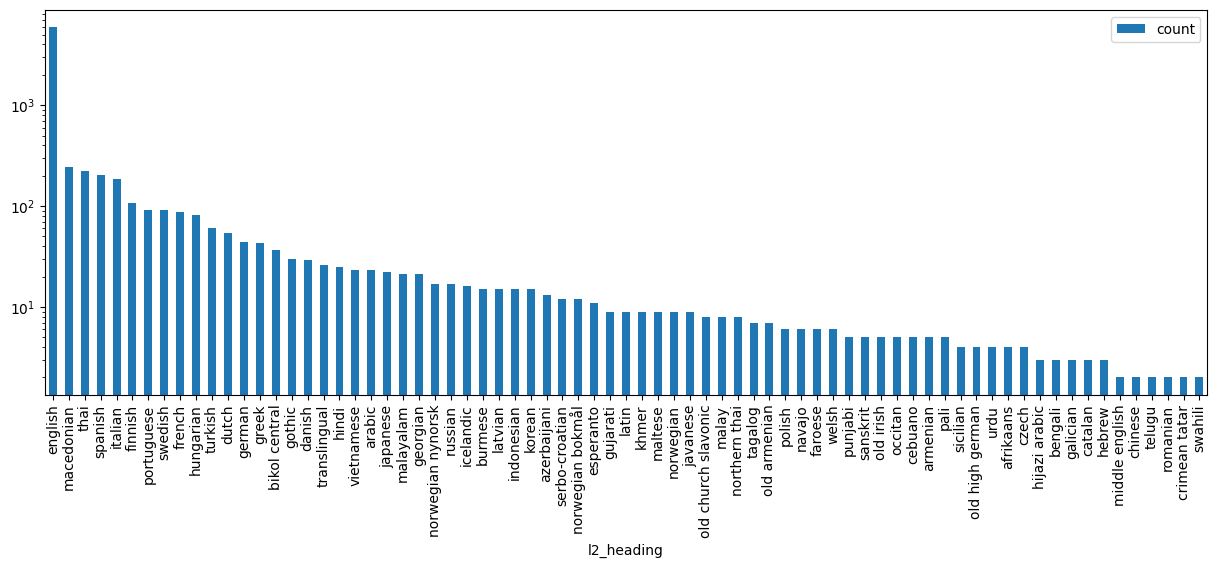

In [42]:
languages[languages["count"]>1].plot(kind="bar", figsize=(15,5), logy=True);

In [59]:
def de_struct(row):
    row["pos"]=row["templates"][0]
    row["ln"]=row["templates"][1]
    row["word"]=row["templates"][2]
    return row
    
df = df.explode("templates").apply(de_struct, axis=1)
df.head()

page_id     page_title l2_heading  num_definitions  num_templates  \
0   101526       ตุ๊กตุ๊ก       thai                1              1   
1   487141      beautyful    english                1              1   
2  1335629  mitochondrium    english                1              1   
3  3422912       bonified    english                2              1   
4  3543701         उदहारण      hindi                1              1   

                    templates        pos  ln           word  
0          (noun, th, ตุ๊ก ๆ)       noun  th         ตุ๊ก ๆ  
1  (adjective, en, beautiful)  adjective  en      beautiful  
2   (noun, en, mitochondrion)       noun  en  mitochondrion  
3  (adjective, en, bona fide)  adjective  en      bona fide  
4          (noun, hi, उदाहरण)       noun  hi         उदाहरण

In [60]:
heading = df.groupby("pos").count().iloc[:,0].sort_values(ascending=False).to_frame().rename(columns={"page_id":"count"})
heading.head(50)

count
pos                        
noun                   4765
adjective              1948
verb                    732
adverb                  375
proper noun             197
interjection             58
pronoun                  50
conjunction              45
contraction              37
phrase                   30
preposition              24
numeral                  16
determiner               13
participle               12
prepositional phrase     12
particle                 11
symbol                    5
prefix                    4
misspelling               2
kanji                     2
proverb                   2
number                    1
idiom                     1
han character             1
suffix                    1
article                   1
verbal noun               1

In [61]:
len(heading)

27

<AxesSubplot: xlabel='pos'>

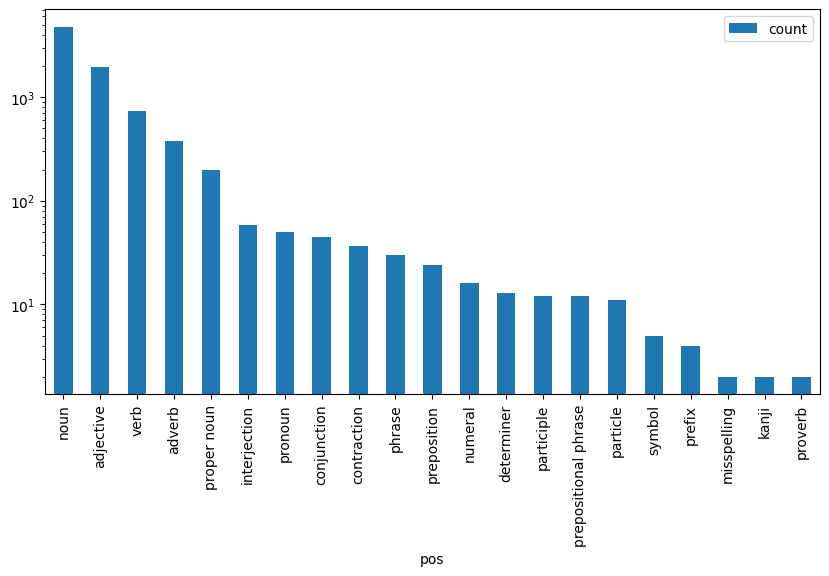

In [62]:
heading[heading["count"]>1].plot(kind="bar", figsize=(10,5), logy=True)

In [63]:
# check that all the same l2_sections have the same langauge
# note that each index is a (page, l2_section), exploding preserves the index

for ix, row in df.iterrows():
    df_row = df.loc[[ix]]
    if(df_row["ln"].nunique() > 1):
        display(df_row)
        
# doesn't print anything, so we're good.